In [1]:
import matplotlib as mlp
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf
from tensorflow import keras 
import warnings

warnings.filterwarnings('ignore')
print(tf.__version__)
for model in sklearn, pd, keras, np ,mlp:
    print(model.__name__, model.__version__)

2.1.0
sklearn 0.20.2
pandas 0.24.2
tensorflow_core.python.keras.api._v2.keras 2.2.4-tf
numpy 1.17.4
matplotlib 2.1.2


In [2]:
# https://storage.googleapis.com/tf-datasets/taitanic/train.csv
# https://storage.googleapis.com/tf-datasets/taitanic/eval.csv
train_file = "./data/titanic/train.csv"
eval_file = "./data/titanic/eval.csv"
train_df = pd.read_csv(train_file)
eval_df = pd.read_csv(eval_file)
train_df.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
train_df = train_df.fillna(method='ffill')
train_df = train_df.dropna(axis=0, how='any')
eval_df = eval_df.fillna(method='ffill').dropna(axis=0, how="any")
print(len(eval_df))
print(train_df.shape)

232
(655, 12)


In [4]:
y_train  = train_df.pop('Survived')
y_eval  = eval_df.pop('Survived')
print(len(y_train))
print(len(y_eval))

655
232


In [5]:
train_df.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,655.000000,655.000000,655.000000,655.000000,655.000000,655.000000
mean,329.000000,2.311450,29.830412,0.532824,0.381679,31.393434
std,189.226496,0.835438,14.634305,1.074478,0.801928,44.974771
min,2.000000,1.000000,0.750000,0.000000,0.000000,0.000000
25%,165.500000,2.000000,21.000000,0.000000,0.000000,7.925000
50%,329.000000,3.000000,28.000000,0.000000,0.000000,15.045800
75%,492.500000,3.000000,38.000000,1.000000,0.000000,30.597900
max,656.000000,3.000000,80.000000,8.000000,5.000000,512.329200


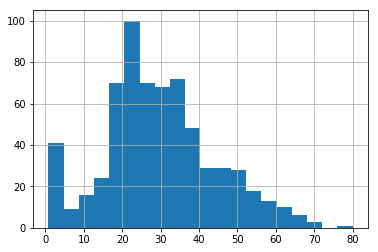

In [6]:
train_df.Age.hist(bins=20)

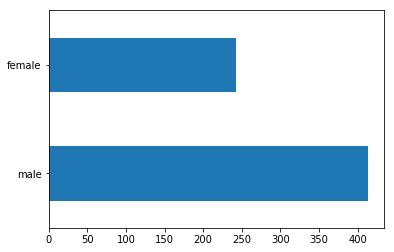

In [7]:
train_df.Sex.value_counts().plot(kind='barh')

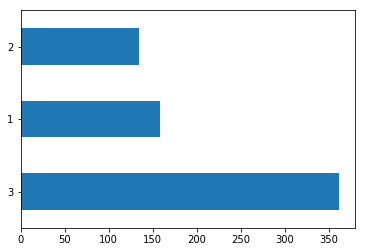

In [8]:
train_df['Pclass'].value_counts().plot(kind='barh')

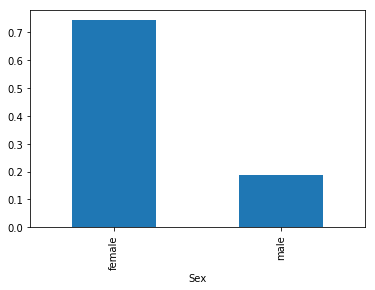

In [9]:
pd.concat([train_df, y_train], axis=1).groupby('Sex').Survived.mean().plot(kind='bar')

In [10]:
pd.concat([train_df, y_train], axis=1).groupby('Sex').head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,C85,S,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,C123,S,0
5,6,3,"Moran, Mr. James",male,35.0,0,0,330877,8.4583,C123,Q,0
6,7,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,0
7,8,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,E46,S,0
8,9,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,E46,S,1
9,10,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,E46,C,1
12,13,3,"Saundercock, Mr. William Henry",male,20.0,0,0,A/5. 2151,8.0500,C103,S,0


In [11]:
# PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
categorical_columns = ['Sex', 'SibSp', 'Parch', 'Pclass', 'Embarked']
numeric_columns = ['Age', 'Fare']
feature_columns = []

for categorical_column in categorical_columns:
    vocab = train_df[categorical_column].unique()
    print(categorical_column, vocab)
    feature_columns.append(
        # 进行one-hot
        tf.feature_column.indicator_column(
            # 将所有可能出现的vocabulary进行分列
            tf.feature_column.categorical_column_with_vocabulary_list(categorical_column, vocab)
        )
    )
    
for numeric in numeric_columns:
    print(numeric)
    feature_columns.append(
        tf.feature_column.numeric_column(numeric, dtype=tf.float32)
    )
print(feature_columns)

Sex ['female' 'male']
SibSp [1 0 3 4 2 5 8]
Parch [0 1 2 5 3 4]
Pclass [1 3 2]
Embarked ['C' 'S' 'Q']
Age
Fare
[IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='Sex', vocabulary_list=('female', 'male'), dtype=tf.string, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='SibSp', vocabulary_list=(1, 0, 3, 4, 2, 5, 8), dtype=tf.int64, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='Parch', vocabulary_list=(0, 1, 2, 5, 3, 4), dtype=tf.int64, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='Pclass', vocabulary_list=(1, 3, 2), dtype=tf.int64, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='Embarked', vocabulary_list=('C', 'S', 'Q'), dtype=tf.string, default_value=-1, num_oov_buckets=0)), NumericColumn(key='Age', shape=(1,), d

In [18]:
def make_dataset(data_df, label_df, epochs=10, shuffle=True, batch_size=32):
    dataset = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))
    if shuffle:
        dataset = dataset.shuffle(1000)
    dataset = dataset.repeat(epochs).batch(batch_size)
    return dataset

In [19]:
train_set = make_dataset(train_df, y_train, batch_size=3)
for x, y in train_set.take(1):
    print(x, y)

{'PassengerId': <tf.Tensor: shape=(3,), dtype=int32, numpy=array([410,  36, 650], dtype=int32)>, 'Pclass': <tf.Tensor: shape=(3,), dtype=int32, numpy=array([3, 1, 3], dtype=int32)>, 'Name': <tf.Tensor: shape=(3,), dtype=string, numpy=
array([b'Lefebre, Miss. Ida', b'Holverson, Mr. Alexander Oskar',
       b'Stanley, Miss. Amy Zillah Elsie'], dtype=object)>, 'Sex': <tf.Tensor: shape=(3,), dtype=string, numpy=array([b'female', b'male', b'female'], dtype=object)>, 'Age': <tf.Tensor: shape=(3,), dtype=float32, numpy=array([21., 42., 23.], dtype=float32)>, 'SibSp': <tf.Tensor: shape=(3,), dtype=int32, numpy=array([3, 1, 0], dtype=int32)>, 'Parch': <tf.Tensor: shape=(3,), dtype=int32, numpy=array([1, 0, 0], dtype=int32)>, 'Ticket': <tf.Tensor: shape=(3,), dtype=string, numpy=array([b'4133', b'113789', b'CA. 2314'], dtype=object)>, 'Fare': <tf.Tensor: shape=(3,), dtype=float32, numpy=array([25.4667, 52.    ,  7.55  ], dtype=float32)>, 'Cabin': <tf.Tensor: shape=(3,), dtype=string, numpy=array

In [20]:
for x, y in train_set.take(1):
    print(keras.layers.DenseFeatures(feature_columns)(x).numpy())

[[ 36.       0.       1.       0.      13.       1.       0.       0.
    0.       0.       0.       0.       0.       1.       1.       0.
    0.       1.       0.       0.       0.       0.       0.    ]
 [ 28.       0.       1.       0.      56.4958   1.       0.       0.
    0.       0.       0.       0.       1.       0.       0.       1.
    0.       1.       0.       0.       0.       0.       0.    ]
 [ 40.       1.       0.       0.     146.5208   1.       0.       0.
    0.       0.       0.       1.       0.       0.       1.       0.
    1.       0.       0.       0.       0.       0.       0.    ]]


In [31]:
model = keras.models.Sequential([
    keras.layers.DenseFeatures(feature_columns),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(2, activation='softmax')
])
# sparse_categorical_crossentropy:  如果y是一个数，会把它转化成一个向量，如 y->index., y->one hot->[]
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


In [33]:
print(eval_df.shape)
print(y_eval.shape)

(232, 11)
(232,)


In [47]:
# 生成数据
train_set = make_dataset(train_df, y_train, epochs=100)
eval_set = make_dataset(eval_df, y_eval, epochs=1, shuffle=False)
# 1.直接fit的方式
history = model.fit(train_set,
                    validation_data=eval_set,
                    steps_per_epoch=656 // 32,
                    validation_steps=263 // 32,
                    epochs=100)



Train for 20 steps, validate for 8 steps
Epoch 1/100
20/20 [==============================] - 1s 42ms/step - loss: 0.8085 - accuracy: 0.6453 - val_loss: 0.7904 - val_accuracy: 0.6853
Epoch 2/100
20/20 [==============================] - 0s 3ms/step - loss: 0.6534 - accuracy: 0.6406 - val_loss: 0.6849 - val_accuracy: 0.7112
Epoch 3/100
20/20 [==============================] - 0s 3ms/step - loss: 0.6418 - accuracy: 0.7016 - val_loss: 0.5351 - val_accuracy: 0.7629
Epoch 4/100
20/20 [==============================] - 0s 3ms/step - loss: 0.5487 - accuracy: 0.7453 - val_loss: 0.5226 - val_accuracy: 0.7672
Epoch 5/100
20/20 [==============================] - 0s 3ms/step - loss: 0.5434 - accuracy: 0.7422 - val_loss: 0.5755 - val_accuracy: 0.7543
Epoch 6/100
20/20 [==============================] - 0s 3ms/step - loss: 0.5417 - accuracy: 0.7594 - val_loss: 0.4632 - val_accuracy: 0.7845
Epoch 7/100
20/20 [==============================] - 0s 3ms/step - loss: 0.5294 - accuracy: 0.7797 - val_loss: 0

20/20 [==============================] - 0s 3ms/step - loss: 0.4160 - accuracy: 0.8266 - val_loss: 0.5311 - val_accuracy: 0.7931
Epoch 59/100
20/20 [==============================] - 0s 3ms/step - loss: 0.4128 - accuracy: 0.8203 - val_loss: 0.4370 - val_accuracy: 0.8017
Epoch 60/100
20/20 [==============================] - 0s 3ms/step - loss: 0.4231 - accuracy: 0.8234 - val_loss: 0.4201 - val_accuracy: 0.8060
Epoch 61/100
20/20 [==============================] - 0s 3ms/step - loss: 0.3719 - accuracy: 0.8438 - val_loss: 0.4323 - val_accuracy: 0.8190
Epoch 62/100
20/20 [==============================] - 0s 3ms/step - loss: 0.4262 - accuracy: 0.8188 - val_loss: 0.3798 - val_accuracy: 0.8103
Epoch 63/100
20/20 [==============================] - 0s 3ms/step - loss: 0.4440 - accuracy: 0.8078 - val_loss: 0.4432 - val_accuracy: 0.8190
Epoch 64/100
20/20 [==============================] - 0s 3ms/step - loss: 0.4166 - accuracy: 0.8359 - val_loss: 0.3889 - val_accuracy: 0.8319
Epoch 65/100
20/20 

In [50]:
# 2.model -> estimator -> train
estimator = keras.estimator.model_to_estimator(model)
estimator.train(input_fn=lambda : make_dataset(train_df, y_train, epochs=100))

W0223 16:57:00.351490 4528813504 estimator.py:1825] Using temporary folder as model directory: /var/folders/lb/t29zgktd10z_cshtlw47bggh0000gn/T/tmp78xi44ev
W0223 16:57:00.354019 4528813504 keras.py:582] You are creating an Estimator from a Keras model manually subclassed from `Model`, that was already called on some inputs (and thus already had weights). We are currently unable to preserve the model's state (its weights) as part of the estimator in this case. Be warned that the estimator has been created using a freshly initialized version of your model.
Note that this doesn't affect the state of the model instance you passed as `keras_model` argument.


ValueError: Unexpectedly found an instance of type `<class 'dict'>`. Expected a symbolic tensor instance.